# RL Training Analysis

This notebook provides tools for analyzing the training logs from our reinforcement learning experiments. We'll visualize how reward and training loss change over time (epochs/episodes) to gain insights into the training progress and model performance.

Key metrics we'll analyze:
- Episode rewards
- Training loss
- Epsilon values (exploration rate)
- Cells saved percentage
- Moving averages and trends

## Import Required Libraries

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['figure.dpi'] = 100

# Import our custom metrics analyzer if available
import sys
sys.path.append('..')  # Add parent directory to path
try:
    from src.rl.utils.logger import MetricsAnalyzer
    HAS_ANALYZER = True
except ImportError:
    print("MetricsAnalyzer not found, using pandas directly instead")
    HAS_ANALYZER = False

## Load Training Log Data

In this section, we'll locate and load the training logs generated by our RL training process. Our logger produces two main types of log files:
1. CSV logs with per-episode details
2. JSON metrics files with aggregated statistics

We'll first define utility functions to find and load these logs, then load the most recent training run by default.

In [2]:
# Define paths to the logs
# For a 10x10 grid, logs will be in outputs/logs/10x10/dqn
base_output_dir = Path('../outputs')
dimensions = '10x10'  # Adjust as needed
logs_dir = base_output_dir / 'logs' / dimensions / 'dqn'

def find_log_files(logs_dir):
    """Find all available log files in the logs directory."""
    logs_dir = Path(logs_dir)
    
    if not logs_dir.exists():
        print(f"Logs directory not found: {logs_dir}")
        return [], []
        
    csv_files = list(logs_dir.glob('training_log_*.csv'))
    json_files = list(logs_dir.glob('training_metrics_*.json'))
    
    # Sort by modification time (newest first)
    csv_files = sorted(csv_files, key=lambda x: x.stat().st_mtime, reverse=True)
    json_files = sorted(json_files, key=lambda x: x.stat().st_mtime, reverse=True)
    
    return csv_files, json_files

def load_log_file(file_path):
    """Load a log file (CSV or JSON) into a pandas DataFrame."""
    file_path = Path(file_path)
    
    if file_path.suffix == '.csv':
        return pd.read_csv(file_path)
    elif file_path.suffix == '.json':
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        # Convert JSON data to DataFrame
        if isinstance(data, dict):
            # Check if the data is already in a structure suitable for DataFrame
            max_length = max(len(value) if isinstance(value, list) else 0 
                             for value in data.values())
            
            # Ensure all lists have the same length
            for key in data:
                if isinstance(data[key], list):
                    if len(data[key]) < max_length:
                        # Pad with None
                        data[key].extend([None] * (max_length - len(data[key])))
            
            return pd.DataFrame(data)
        else:
            # If it's a list of records, use the default conversion
            return pd.DataFrame(data)
    else:
        raise ValueError(f"Unsupported file format: {file_path.suffix}")

# Find available log files
csv_files, json_files = find_log_files(logs_dir)

# Print available files for selection
print("Available CSV log files:")
for i, f in enumerate(csv_files):
    print(f"[{i}] {f.name} (Modified: {pd.to_datetime(f.stat().st_mtime, unit='s')})")

print("\nAvailable JSON metrics files:")
for i, f in enumerate(json_files):
    print(f"[{i}] {f.name} (Modified: {pd.to_datetime(f.stat().st_mtime, unit='s')})")

Available CSV log files:
[0] training_log_20250626_140920.csv (Modified: 2025-06-26 12:42:12.164740086)

Available JSON metrics files:
[0] training_metrics_20250626_140920.json (Modified: 2025-06-26 12:42:45.981175661)


In [3]:
# Load the most recent log file (or specify an index to load a different one)
# For demonstration, we'll load data conditionally since we don't know if any logs exist yet

# Function to load with MetricsAnalyzer or directly with pandas
def load_metrics_data():
    """Load training metrics data using MetricsAnalyzer if available, or pandas otherwise."""
    if not (csv_files or json_files):
        print("No log files found. Run training first.")
        return None
        
    if HAS_ANALYZER:
        # Use our custom MetricsAnalyzer class
        if csv_files:
            analyzer = MetricsAnalyzer(log_path=str(csv_files[0]))
            print(f"Loaded CSV log: {csv_files[0].name}")
        else:
            analyzer = MetricsAnalyzer(log_path=str(json_files[0]))
            print(f"Loaded JSON metrics: {json_files[0].name}")
        
        return analyzer
    else:
        # Use pandas directly
        if csv_files:
            df = load_log_file(csv_files[0])
            print(f"Loaded CSV log: {csv_files[0].name}")
        else:
            df = load_log_file(json_files[0])
            print(f"Loaded JSON metrics: {json_files[0].name}")
            
        return df

# Load the data
log_data = load_metrics_data()

# Check if we got an analyzer object or a dataframe
if HAS_ANALYZER and log_data is not None:
    # We got an analyzer object
    df = log_data.data
    print(f"Loaded log with {len(df)} entries")
    df.head()
elif log_data is not None:
    # We got a dataframe directly
    df = log_data
    print(f"Loaded log with {len(df)} entries")
    df.head()
else:
    print("No data loaded. Please run training first to generate logs.")

Loaded log with 5000 entries
Loaded CSV log: training_log_20250626_140920.csv
Loaded log with 5000 entries


## Visualize Reward Over Time

Now let's visualize how the reward changes over the course of training. We'll create plots showing:
1. Raw episode rewards
2. Moving average rewards to identify trends
3. Distribution of rewards to understand the learning progress

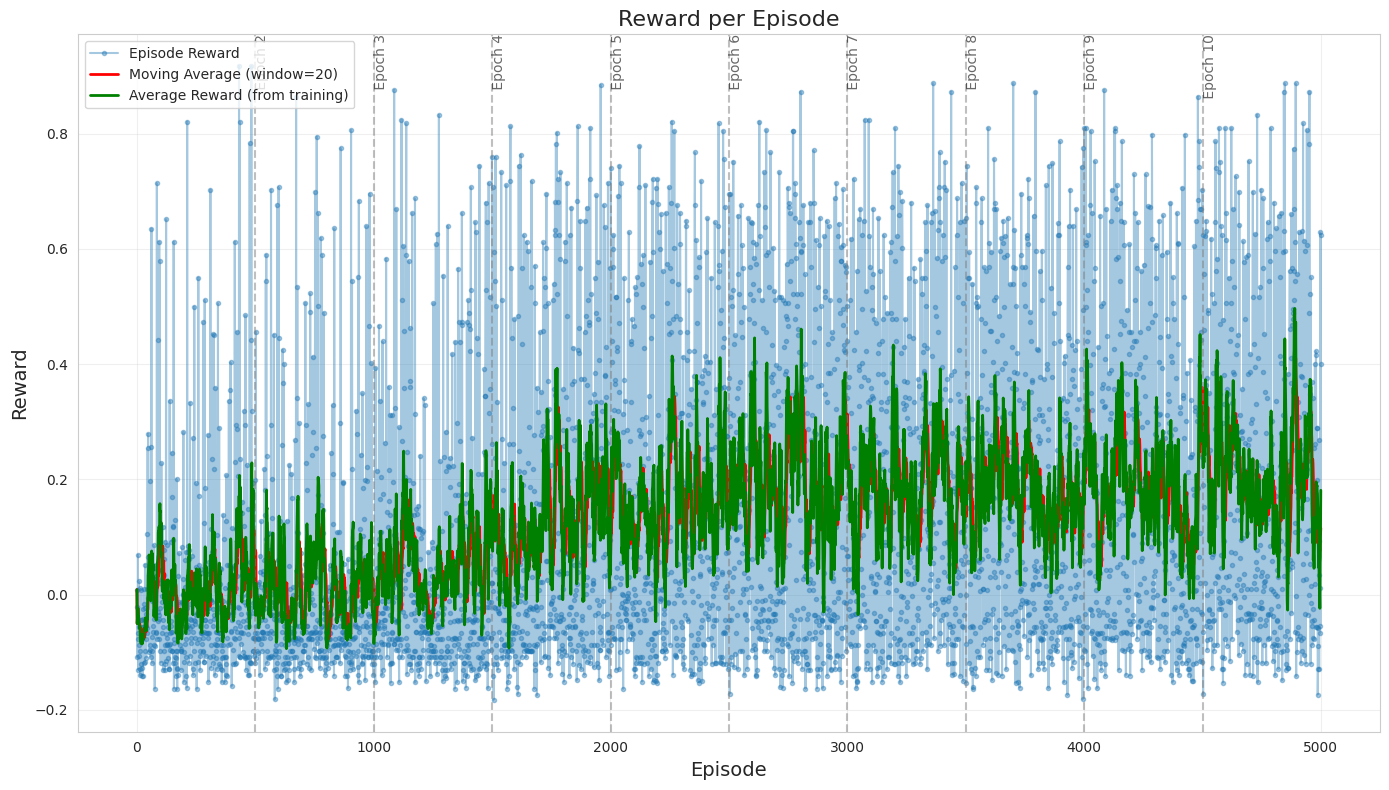

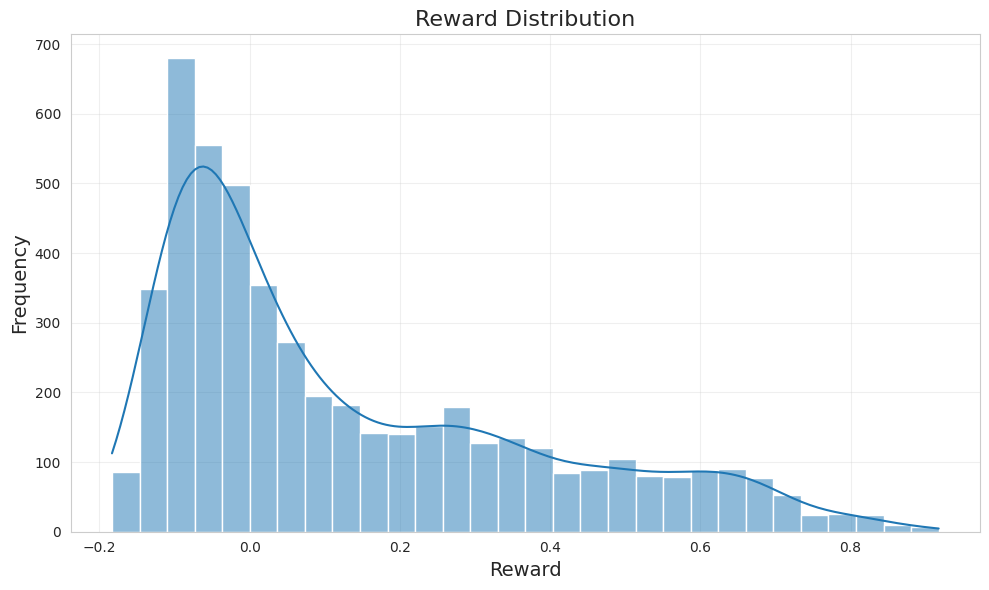

In [4]:
def plot_rewards(df, window_size=10, figsize=(14, 8)):
    """
    Plot episode rewards and moving average.
    
    Args:
        df: DataFrame with training log data
        window_size: Window size for moving average
        figsize: Figure size
    """
    # Check if we have the necessary data
    if df is None or 'reward' not in df.columns:
        print("No reward data found in the logs.")
        return
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot raw rewards
    ax.plot(df['episode'], df['reward'], 'o-', alpha=0.4, label='Episode Reward', markersize=3)
    
    # Plot moving average
    reward_ma = df['reward'].rolling(window=window_size, min_periods=1).mean()
    ax.plot(df['episode'], reward_ma, 'r-', linewidth=2, label=f'Moving Average (window={window_size})')
    
    # If we have epoch data, add vertical lines to separate epochs
    if 'epoch' in df.columns and len(df['epoch'].unique()) > 1:
        for epoch in sorted(df['epoch'].unique())[1:]:
            epoch_start_idx = df[df['epoch'] == epoch].index[0]
            episode_num = df.loc[epoch_start_idx, 'episode']
            ax.axvline(x=episode_num, color='gray', linestyle='--', alpha=0.5)
            ax.text(episode_num, ax.get_ylim()[1], f' Epoch {epoch}', 
                    verticalalignment='top', horizontalalignment='left',
                    rotation=90, alpha=0.7)
    
    # If we have avg_reward already calculated, also plot that
    if 'avg_reward' in df.columns:
        ax.plot(df['episode'], df['avg_reward'], 'g-', linewidth=2, 
                label='Average Reward (from training)')
    
    ax.set_title('Reward per Episode', fontsize=16)
    ax.set_xlabel('Episode', fontsize=14)
    ax.set_ylabel('Reward', fontsize=14)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Also show a histogram of rewards
    plt.figure(figsize=(10, 6))
    sns.histplot(df['reward'], kde=True, bins=30)
    plt.title('Reward Distribution', fontsize=16)
    plt.xlabel('Reward', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot rewards if data is available
if 'df' in locals() and df is not None and 'reward' in df.columns:
    plot_rewards(df, window_size=20)
else:
    print("No reward data available to plot.")

## Visualize Training Loss Over Time

Let's analyze the training loss to understand how well our model is learning over time. We'll create:
1. A line plot of training loss per episode
2. Moving average to identify trends
3. A histogram to understand the distribution of losses

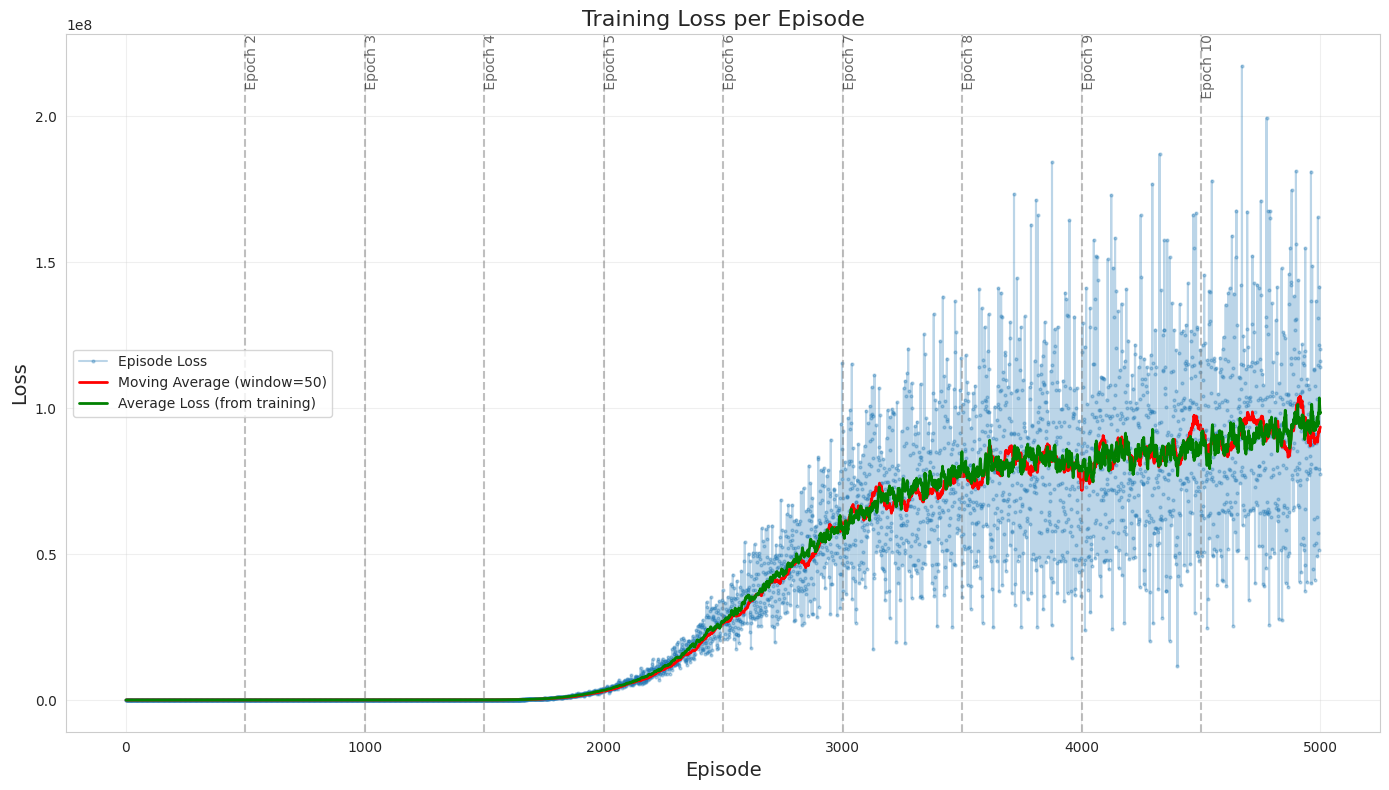

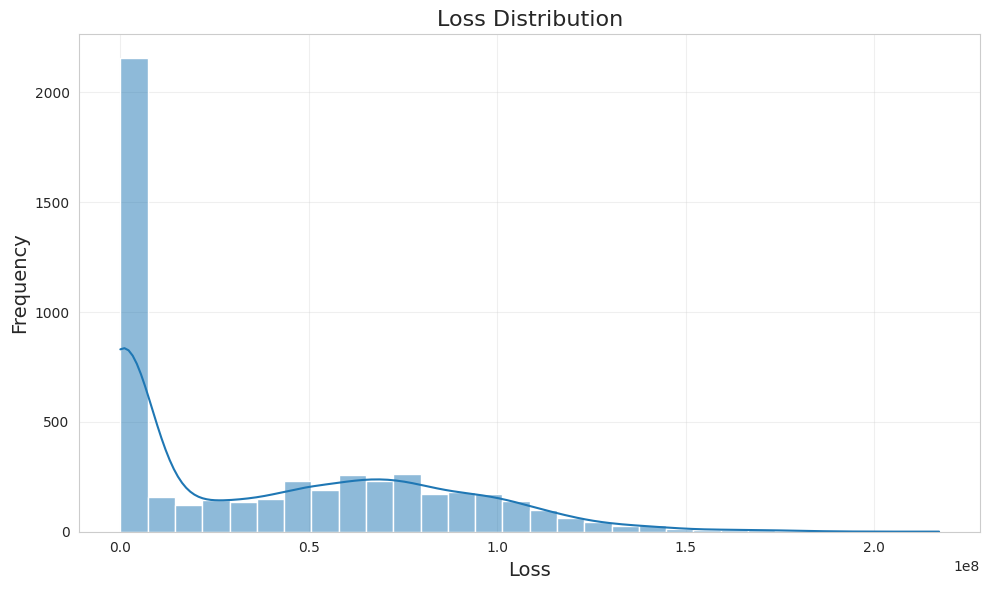

In [5]:
def plot_loss(df, window_size=50, figsize=(14, 8)):
    """
    Plot training loss and moving average.
    
    Args:
        df: DataFrame with training log data
        window_size: Window size for moving average
        figsize: Figure size
    """
    # Check if we have the necessary data
    if df is None or 'loss' not in df.columns:
        print("No loss data found in the logs.")
        return
    
    # Filter out NaN values and extremely high outliers
    df_loss = df[df['loss'].notna()]
    loss_mean = df_loss['loss'].mean()
    loss_std = df_loss['loss'].std()
    
    # Filter outliers more than 5 standard deviations from the mean
    df_loss = df_loss[abs(df_loss['loss'] - loss_mean) < 5 * loss_std]
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot raw loss
    ax.plot(df_loss['episode'], df_loss['loss'], 'o-', alpha=0.3, label='Episode Loss', markersize=2)
    
    # Plot moving average
    loss_ma = df_loss['loss'].rolling(window=window_size, min_periods=1).mean()
    ax.plot(df_loss['episode'], loss_ma, 'r-', linewidth=2, label=f'Moving Average (window={window_size})')
    
    # If we have epoch data, add vertical lines to separate epochs
    if 'epoch' in df_loss.columns and len(df_loss['epoch'].unique()) > 1:
        for epoch in sorted(df_loss['epoch'].unique())[1:]:
            epoch_data = df_loss[df_loss['epoch'] == epoch]
            if len(epoch_data) > 0:
                episode_num = epoch_data['episode'].iloc[0]
                ax.axvline(x=episode_num, color='gray', linestyle='--', alpha=0.5)
                ax.text(episode_num, ax.get_ylim()[1], f' Epoch {epoch}', 
                        verticalalignment='top', horizontalalignment='left',
                        rotation=90, alpha=0.7)
    
    # If we have avg_loss already calculated, also plot that
    if 'avg_loss' in df_loss.columns:
        ax.plot(df_loss['episode'], df_loss['avg_loss'], 'g-', linewidth=2, 
                label='Average Loss (from training)')
    
    ax.set_title('Training Loss per Episode', fontsize=16)
    ax.set_xlabel('Episode', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Also show a histogram of losses
    plt.figure(figsize=(10, 6))
    sns.histplot(df_loss['loss'], kde=True, bins=30)
    plt.title('Loss Distribution', fontsize=16)
    plt.xlabel('Loss', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
# Plot losses if data is available
if 'df' in locals() and df is not None and 'loss' in df.columns:
    plot_loss(df, window_size=50)
else:
    print("No loss data available to plot.")

## Analyze Reward and Loss Trends

In this section, we'll perform a more detailed analysis of the relationship between rewards and losses. We'll look at:
1. Joint plots to identify correlations
2. Moving averages across different window sizes
3. Episode-by-episode comparison of reward and loss

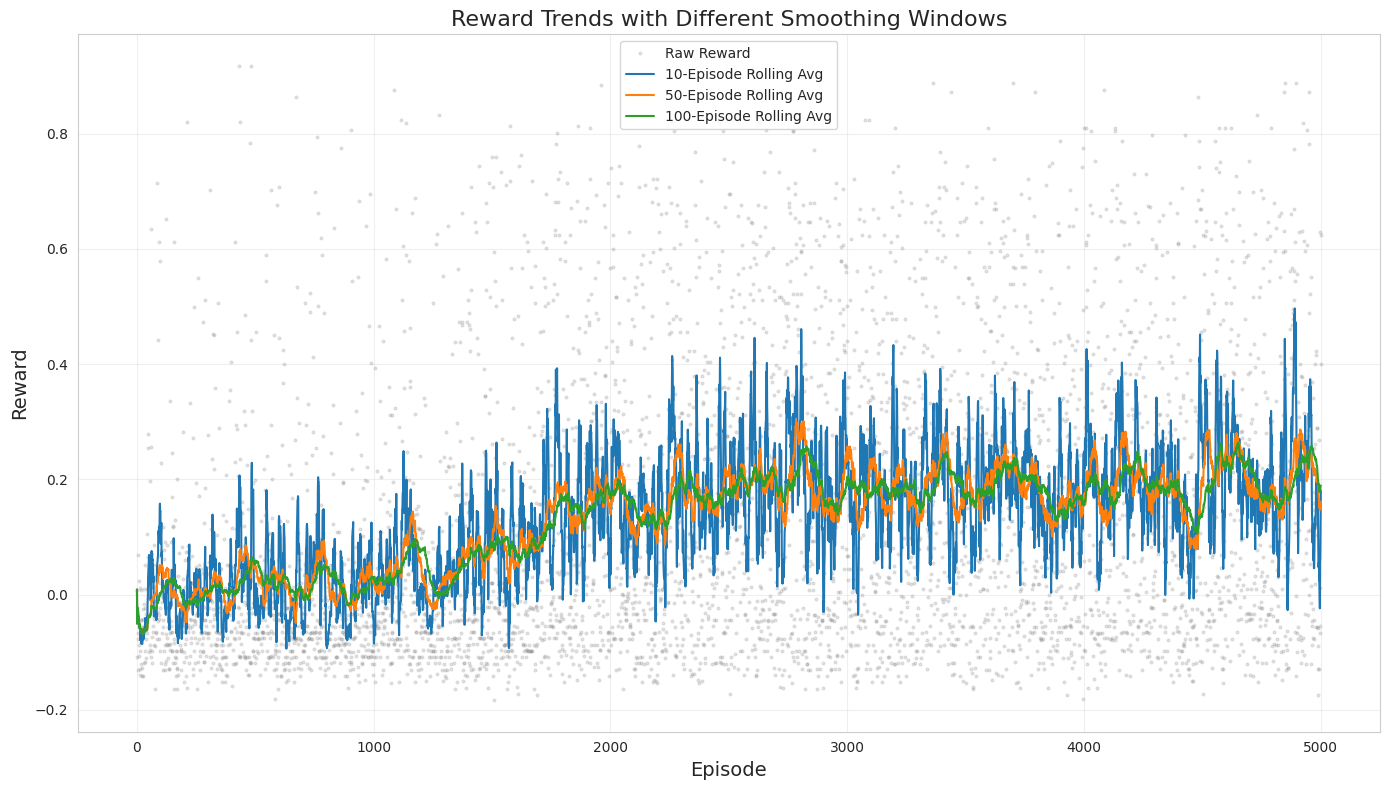

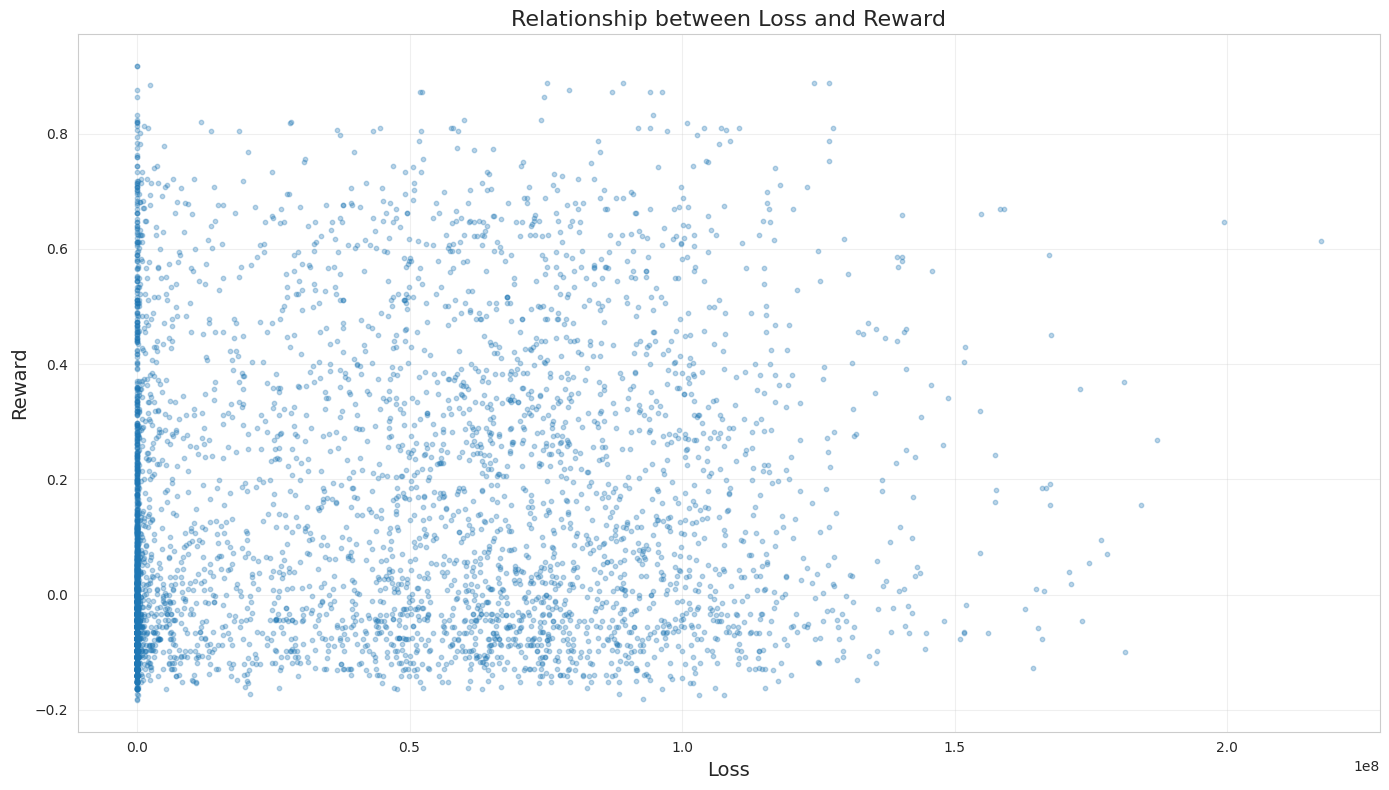

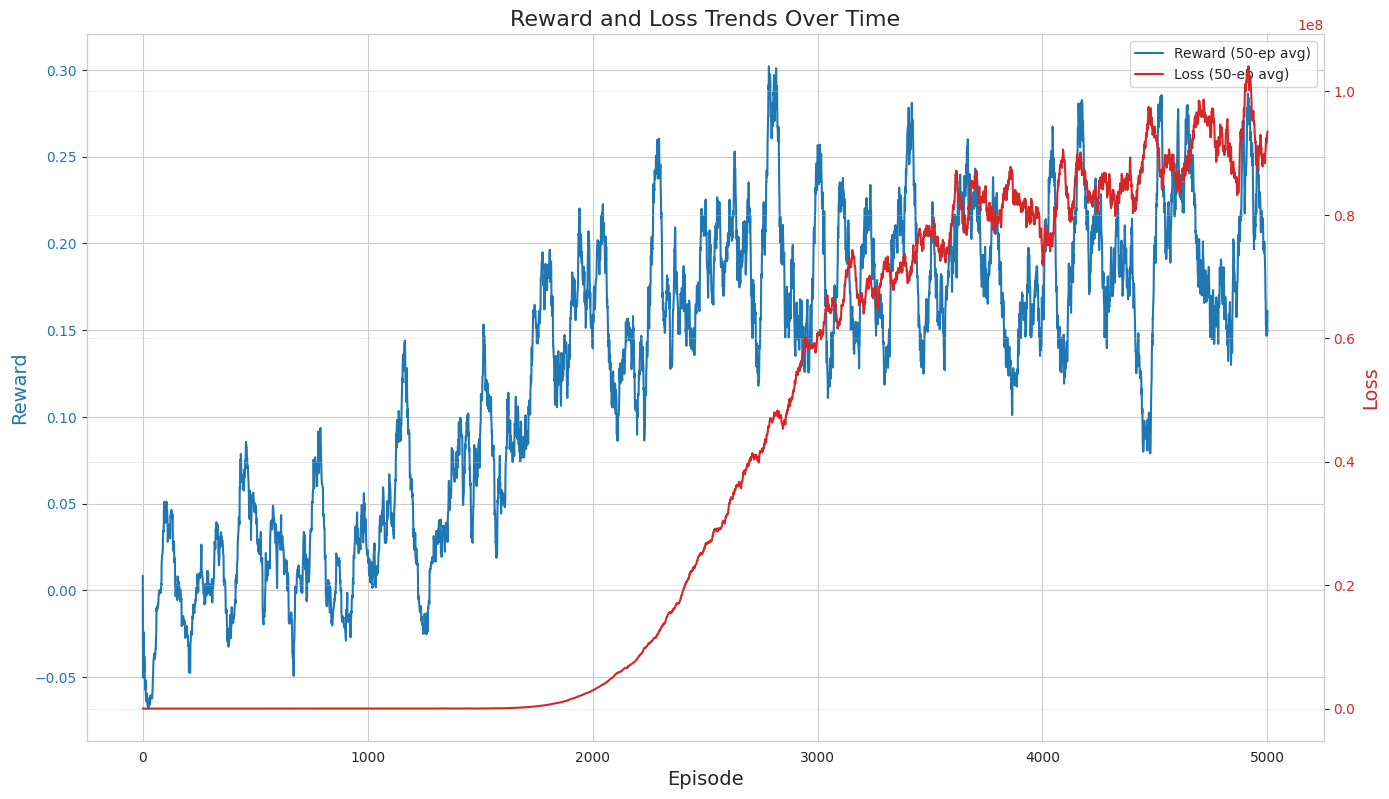

Correlation between reward and loss: 0.2122

Reward Summary Statistics:
count    5000.000000
mean        0.132139
std         0.249042
min        -0.183145
25%        -0.065298
50%         0.034129
75%         0.286775
max         0.917314
Name: reward, dtype: float64

Loss Summary Statistics:
count    5.000000e+03
mean     3.856195e+07
std      4.169978e+07
min      0.000000e+00
25%      2.312699e+02
50%      2.555987e+07
75%      7.190425e+07
max      2.171483e+08
Name: loss, dtype: float64


In [6]:
def analyze_trends(df, figsize=(14, 8)):
    """
    Analyze relationships between reward and loss over time.
    
    Args:
        df: DataFrame with training log data
        figsize: Figure size
    """
    # Check if we have the necessary data
    if df is None or 'reward' not in df.columns or 'loss' not in df.columns:
        print("Both reward and loss data are needed for trend analysis.")
        return
    
    # Filter out NaN values
    df_clean = df.dropna(subset=['reward', 'loss'])
    
    # Filter outliers for loss (more than 5 standard deviations from the mean)
    loss_mean = df_clean['loss'].mean()
    loss_std = df_clean['loss'].std()
    df_clean = df_clean[abs(df_clean['loss'] - loss_mean) < 5 * loss_std]
    
    # Calculate additional rolling statistics with different window sizes
    df_clean['reward_roll_short'] = df_clean['reward'].rolling(window=10, min_periods=1).mean()
    df_clean['reward_roll_medium'] = df_clean['reward'].rolling(window=50, min_periods=1).mean()
    df_clean['reward_roll_long'] = df_clean['reward'].rolling(window=100, min_periods=1).mean()
    
    df_clean['loss_roll_short'] = df_clean['loss'].rolling(window=10, min_periods=1).mean()
    df_clean['loss_roll_medium'] = df_clean['loss'].rolling(window=50, min_periods=1).mean()
    df_clean['loss_roll_long'] = df_clean['loss'].rolling(window=100, min_periods=1).mean()
    
    # Plot multiple rolling averages on reward
    plt.figure(figsize=figsize)
    plt.plot(df_clean['episode'], df_clean['reward'], 'o', markersize=2, 
             alpha=0.2, color='gray', label='Raw Reward')
    plt.plot(df_clean['episode'], df_clean['reward_roll_short'], 
             label='10-Episode Rolling Avg')
    plt.plot(df_clean['episode'], df_clean['reward_roll_medium'], 
             label='50-Episode Rolling Avg')
    plt.plot(df_clean['episode'], df_clean['reward_roll_long'], 
             label='100-Episode Rolling Avg')
    
    plt.title('Reward Trends with Different Smoothing Windows', fontsize=16)
    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Reward', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Create a joint plot to analyze relationship between reward and loss
    plt.figure(figsize=figsize)
    plt.scatter(df_clean['loss'], df_clean['reward'], alpha=0.3, s=10)
    plt.title('Relationship between Loss and Reward', fontsize=16)
    plt.xlabel('Loss', fontsize=14)
    plt.ylabel('Reward', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Create a dual axis plot to compare reward and loss trends over time
    fig, ax1 = plt.subplots(figsize=figsize)
    
    color = 'tab:blue'
    ax1.set_xlabel('Episode', fontsize=14)
    ax1.set_ylabel('Reward', color=color, fontsize=14)
    ax1.plot(df_clean['episode'], df_clean['reward_roll_medium'], color=color, label='Reward (50-ep avg)')
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Loss', color=color, fontsize=14)
    ax2.plot(df_clean['episode'], df_clean['loss_roll_medium'], color=color, label='Loss (50-ep avg)')
    ax2.tick_params(axis='y', labelcolor=color)
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')
    
    fig.tight_layout()
    plt.title('Reward and Loss Trends Over Time', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Show correlation statistics
    correlation = df_clean['reward'].corr(df_clean['loss'])
    print(f"Correlation between reward and loss: {correlation:.4f}")
    
    # Calculate and print summary statistics
    print("\nReward Summary Statistics:")
    print(df_clean['reward'].describe())
    
    print("\nLoss Summary Statistics:")
    print(df_clean['loss'].describe())

# Analyze trends if data is available
if 'df' in locals() and df is not None and 'reward' in df.columns and 'loss' in df.columns:
    analyze_trends(df)
else:
    print("Both reward and loss data are required for trend analysis.")

## Visualize Game Score (Cells Saved)

In addition to rewards and losses, let's analyze the actual game performance in terms of cells saved. This metric represents the number of cells that are still alive at the end of each episode, which is a direct measure of how well the agent is performing at its task of protecting cells from fire.

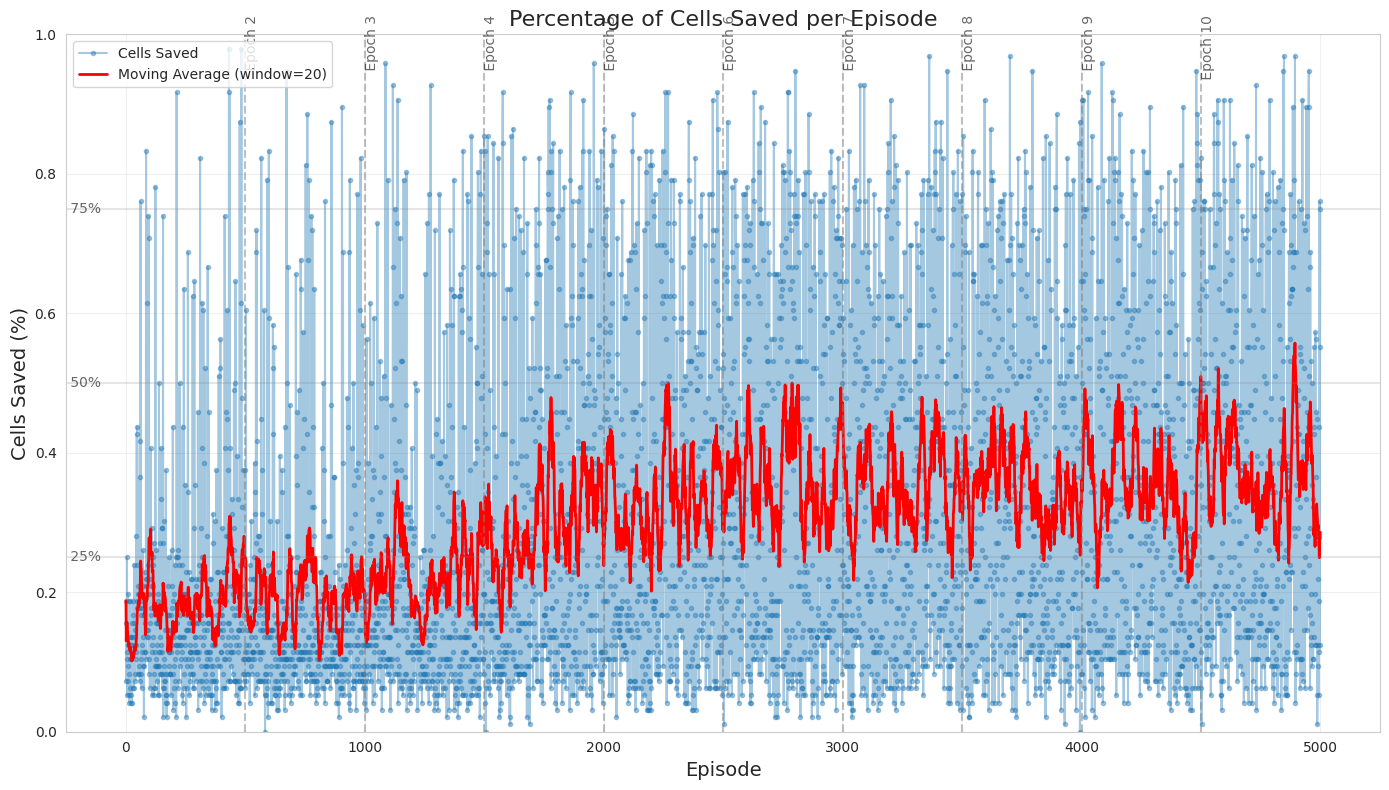

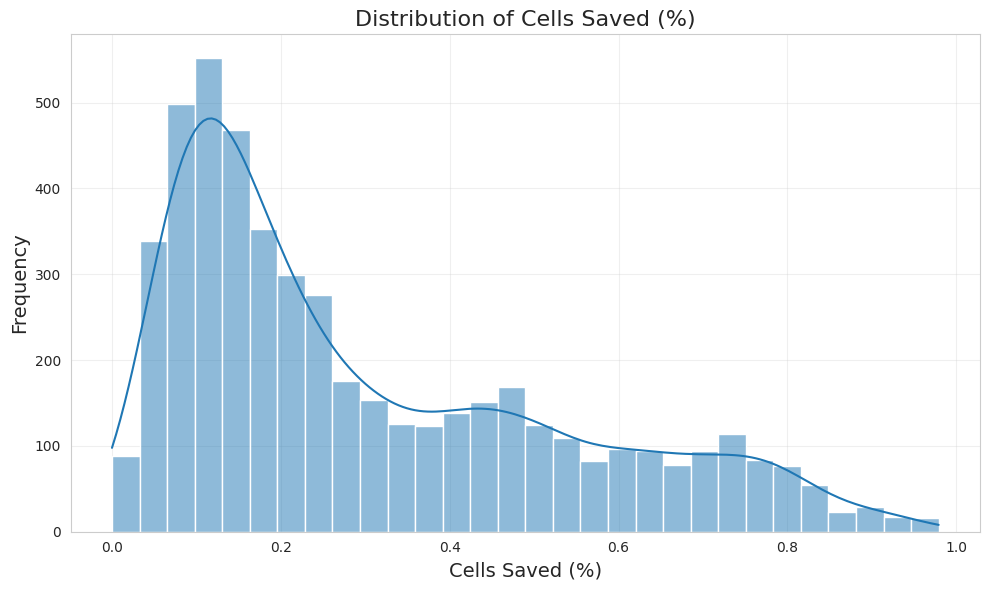


Percentage of Cells Saved per Episode Statistics:
count    5000.000000
mean        0.301875
std         0.231811
min         0.000000
25%         0.114583
50%         0.218750
75%         0.458333
max         0.979167
Name: cells_saved_pct, dtype: float64

Improvement Analysis:
First 25% of episodes average: 0.1949
Last 25% of episodes average: 0.3549
Improvement: 82.10%


In [7]:
def plot_cells_saved(df, window_size=10, figsize=(14, 8)):
    """
    Plot the game score (cells saved) over time.
    
    Args:
        df: DataFrame with training log data
        window_size: Window size for moving average
        figsize: Figure size
    """
    # Check if we have the necessary data
    if df is None:
        print("No data available.")
        return
    
    # Check for cells_saved_pct first (from training logs)
    if 'cells_saved_pct' in df.columns:
        score_col = 'cells_saved_pct'
        title = 'Percentage of Cells Saved per Episode'
        ylabel = 'Cells Saved (%)'
    # If not available, check if we have raw cells_saved count
    elif 'cells_saved' in df.columns:
        score_col = 'cells_saved'
        title = 'Number of Cells Saved per Episode'
        ylabel = 'Cells Saved'
    else:
        print("No cells saved data found in the logs.")
        return
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot raw scores
    ax.plot(df['episode'], df[score_col], 'o-', alpha=0.4, label='Cells Saved', markersize=3)
    
    # Plot moving average
    score_ma = df[score_col].rolling(window=window_size, min_periods=1).mean()
    ax.plot(df['episode'], score_ma, 'r-', linewidth=2, label=f'Moving Average (window={window_size})')
    
    # If we have epoch data, add vertical lines to separate epochs
    if 'epoch' in df.columns and len(df['epoch'].unique()) > 1:
        for epoch in sorted(df['epoch'].unique())[1:]:
            epoch_start_idx = df[df['epoch'] == epoch].index[0]
            episode_num = df.loc[epoch_start_idx, 'episode']
            ax.axvline(x=episode_num, color='gray', linestyle='--', alpha=0.5)
            ax.text(episode_num, ax.get_ylim()[1], f' Epoch {epoch}', 
                    verticalalignment='top', horizontalalignment='left',
                    rotation=90, alpha=0.7)
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Episode', fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # If percentage, set y-axis limits between 0 and 1
    if score_col == 'cells_saved_pct':
        ax.set_ylim(0, 1)
        # Add horizontal lines for reference
        for pct in [0.25, 0.5, 0.75]:
            ax.axhline(y=pct, color='gray', linestyle='-', alpha=0.2)
            ax.text(ax.get_xlim()[0], pct, f' {int(pct*100)}%', 
                    verticalalignment='center', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Also show a histogram of cells saved
    plt.figure(figsize=(10, 6))
    sns.histplot(df[score_col], kde=True, bins=30)
    plt.title(f'Distribution of {ylabel}', fontsize=16)
    plt.xlabel(ylabel, fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"\n{title} Statistics:")
    print(df[score_col].describe())
    
    # Calculate improvement over training
    first_quarter = df[score_col].iloc[:len(df)//4].mean()
    last_quarter = df[score_col].iloc[-len(df)//4:].mean()
    improvement = (last_quarter - first_quarter) / first_quarter * 100 if first_quarter > 0 else float('inf')
    
    print(f"\nImprovement Analysis:")
    print(f"First 25% of episodes average: {first_quarter:.4f}")
    print(f"Last 25% of episodes average: {last_quarter:.4f}")
    print(f"Improvement: {improvement:.2f}%")

# Plot cells saved if data is available
if 'df' in locals() and df is not None:
    if 'cells_saved_pct' in df.columns or 'cells_saved' in df.columns:
        plot_cells_saved(df, window_size=20)
    else:
        print("No cells saved data available to plot.")
else:
    print("No data available to plot.")

## Compare Reward vs Game Score

Let's analyze how the reward correlates with the actual game score (cells saved). This can help us understand if our reward function is effectively guiding the agent toward the desired behavior.

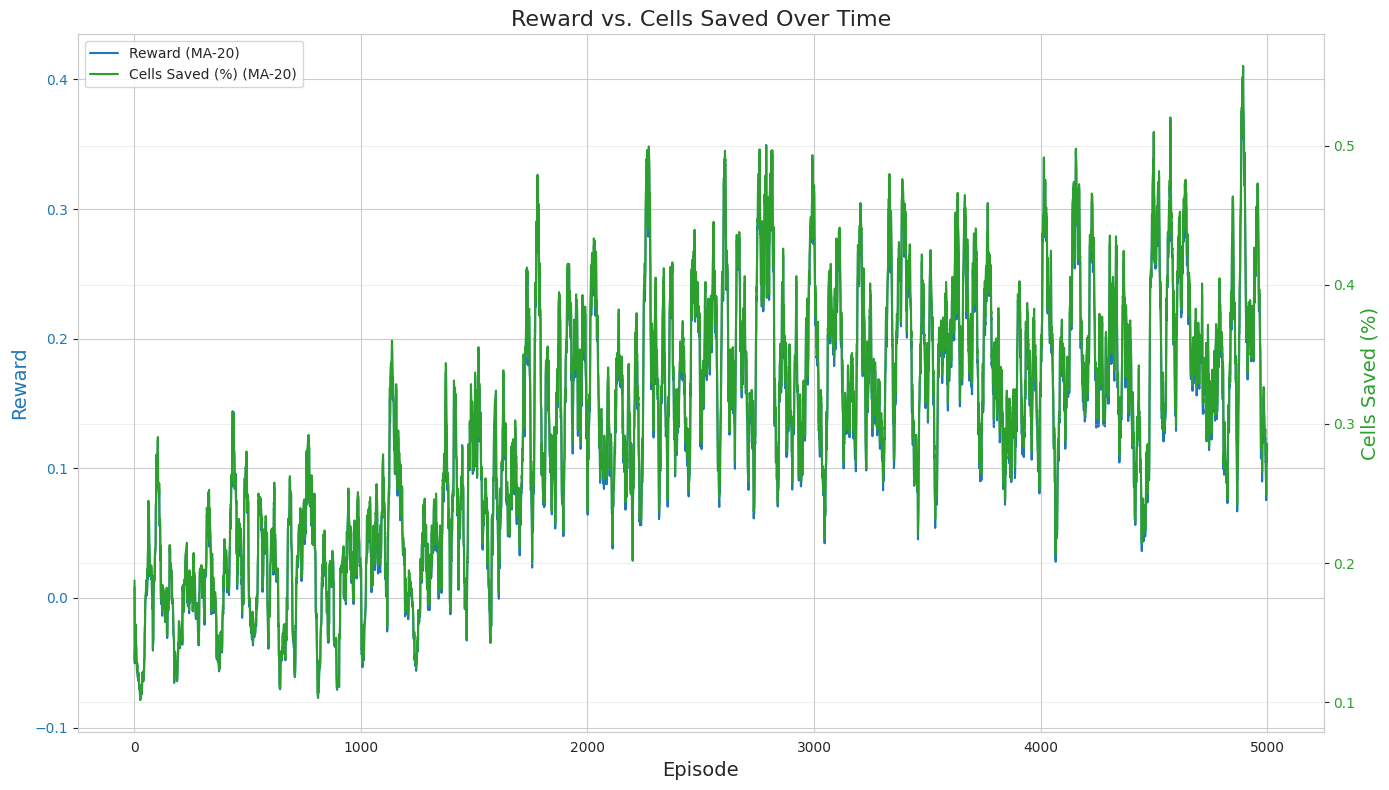

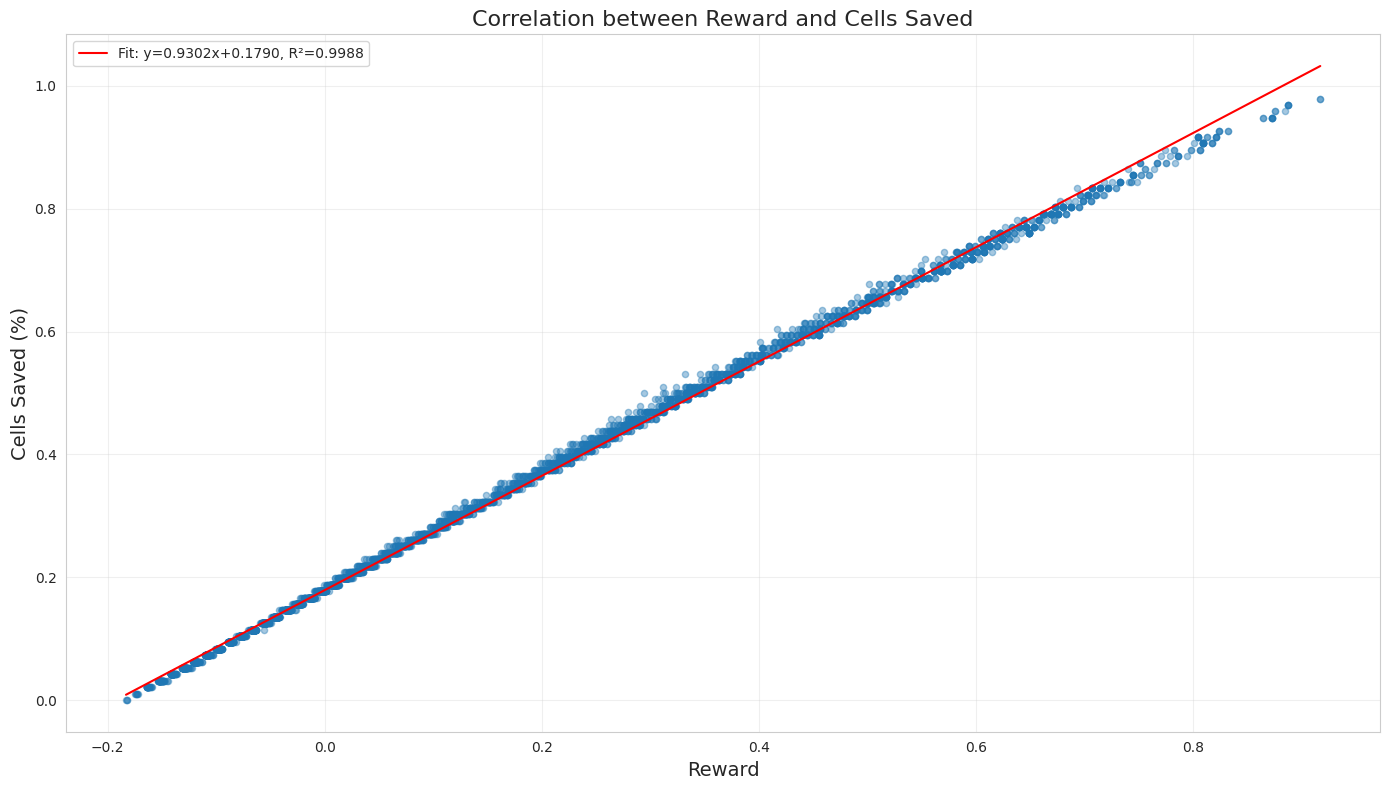

Correlation between reward and cells saved (%): 0.9994
R-squared: 0.9988
P-value: 0.000000


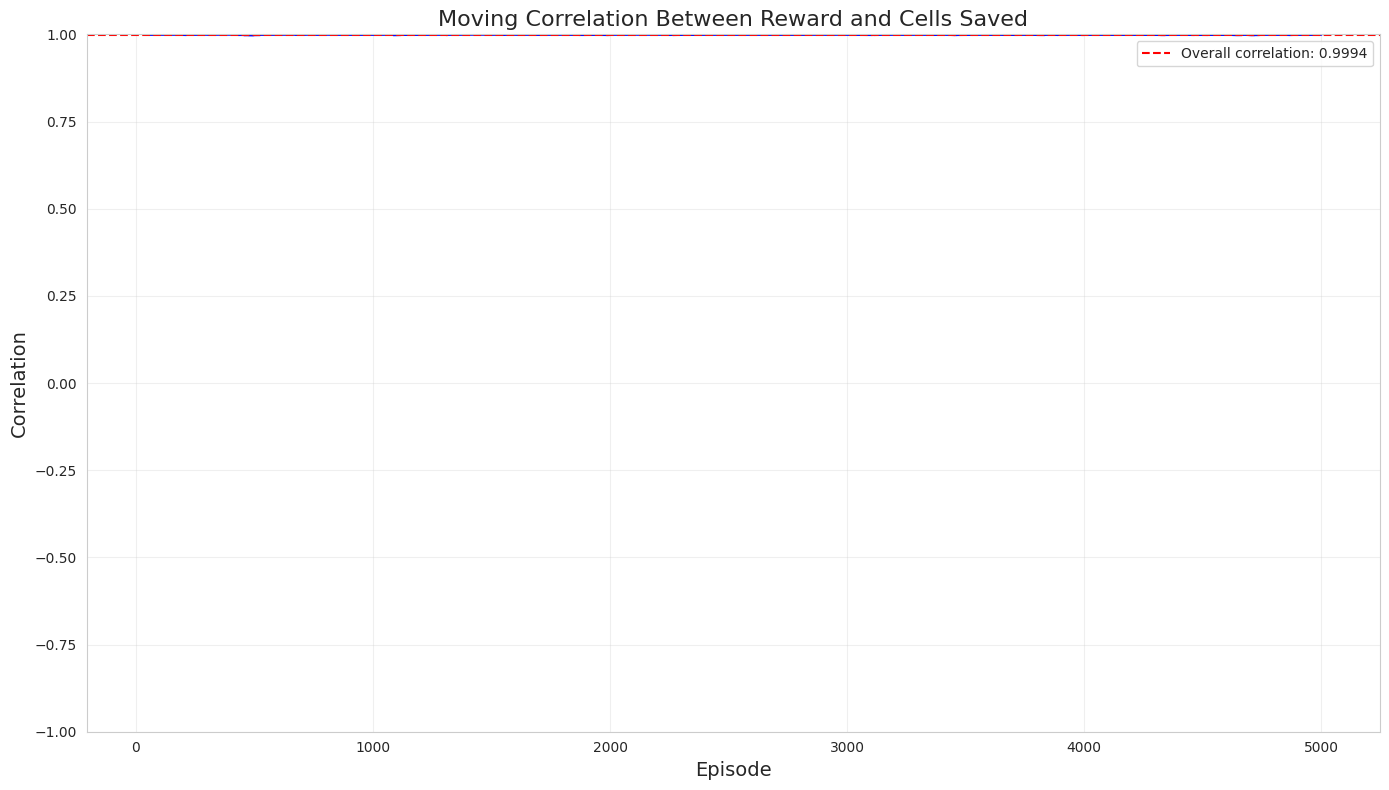


Reward Function Analysis:
The reward function is strongly aligned with saving cells.


In [8]:
def compare_reward_and_score(df, window_size=20, figsize=(14, 8)):
    """
    Compare reward and cells saved metrics to analyze how they correlate.
    
    Args:
        df: DataFrame with training log data
        window_size: Window size for moving average
        figsize: Figure size
    """
    # Check if we have the necessary data
    if df is None or 'reward' not in df.columns:
        print("Reward data is missing.")
        return
    
    # Determine which score column to use
    score_col = None
    if 'cells_saved_pct' in df.columns:
        score_col = 'cells_saved_pct'
        score_label = 'Cells Saved (%)'
    elif 'cells_saved' in df.columns:
        score_col = 'cells_saved'
        score_label = 'Cells Saved'
        
    if score_col is None:
        print("No cells saved data found in the logs.")
        return
    
    # Filter out NaN values
    df_clean = df.dropna(subset=['reward', score_col])
    
    # Calculate moving averages for smoothing
    reward_ma = df_clean['reward'].rolling(window=window_size, min_periods=1).mean()
    score_ma = df_clean[score_col].rolling(window=window_size, min_periods=1).mean()
    
    # 1. Plot side by side smoothed trends
    fig, ax1 = plt.subplots(figsize=figsize)
    
    color1 = 'tab:blue'
    ax1.set_xlabel('Episode', fontsize=14)
    ax1.set_ylabel('Reward', color=color1, fontsize=14)
    ax1.plot(df_clean['episode'], reward_ma, color=color1, label=f'Reward (MA-{window_size})')
    ax1.tick_params(axis='y', labelcolor=color1)
    
    ax2 = ax1.twinx()
    color2 = 'tab:green'
    ax2.set_ylabel(score_label, color=color2, fontsize=14)
    ax2.plot(df_clean['episode'], score_ma, color=color2, label=f'{score_label} (MA-{window_size})')
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')
    
    plt.title('Reward vs. Cells Saved Over Time', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 2. Scatter plot to show correlation
    plt.figure(figsize=figsize)
    plt.scatter(df_clean['reward'], df_clean[score_col], alpha=0.4, s=20)
    plt.title('Correlation between Reward and Cells Saved', fontsize=16)
    plt.xlabel('Reward', fontsize=14)
    plt.ylabel(score_label, fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # Add trend line
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_clean['reward'], df_clean[score_col])
    x = np.array([df_clean['reward'].min(), df_clean['reward'].max()])
    plt.plot(x, intercept + slope * x, 'r-', 
             label=f'Fit: y={slope:.4f}x+{intercept:.4f}, R²={r_value**2:.4f}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 3. Calculate and print correlation statistics
    correlation = df_clean['reward'].corr(df_clean[score_col])
    print(f"Correlation between reward and {score_label.lower()}: {correlation:.4f}")
    print(f"R-squared: {r_value**2:.4f}")
    print(f"P-value: {p_value:.6f}")
    
    # 4. Calculate moving correlation
    # This shows how correlation changes during training
    df_clean['rolling_corr'] = df_clean['reward'].rolling(window=window_size*2).corr(df_clean[score_col])
    
    plt.figure(figsize=figsize)
    plt.plot(df_clean['episode'], df_clean['rolling_corr'], 'b-', linewidth=2)
    plt.axhline(y=correlation, color='r', linestyle='--', 
                label=f'Overall correlation: {correlation:.4f}')
    plt.title('Moving Correlation Between Reward and Cells Saved', fontsize=16)
    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Correlation', fontsize=14)
    plt.ylim(-1, 1)  # Correlation ranges from -1 to 1
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nReward Function Analysis:")
    if correlation > 0.8:
        print("The reward function is strongly aligned with saving cells.")
    elif correlation > 0.5:
        print("The reward function is moderately aligned with saving cells.")
    elif correlation > 0:
        print("The reward function is weakly aligned with saving cells.")
    else:
        print("The reward function may not be aligned with the goal of saving cells.")

# Compare reward and cells saved if data is available
if 'df' in locals() and df is not None and 'reward' in df.columns:
    if 'cells_saved_pct' in df.columns or 'cells_saved' in df.columns:
        compare_reward_and_score(df)
    else:
        print("No cells saved data available for comparison.")

## Analyze Progress across Episodes

Let's analyze how the game score (cells saved) changes with continued training. This will help us understand if the agent's performance is improving over time and how quickly it's learning.

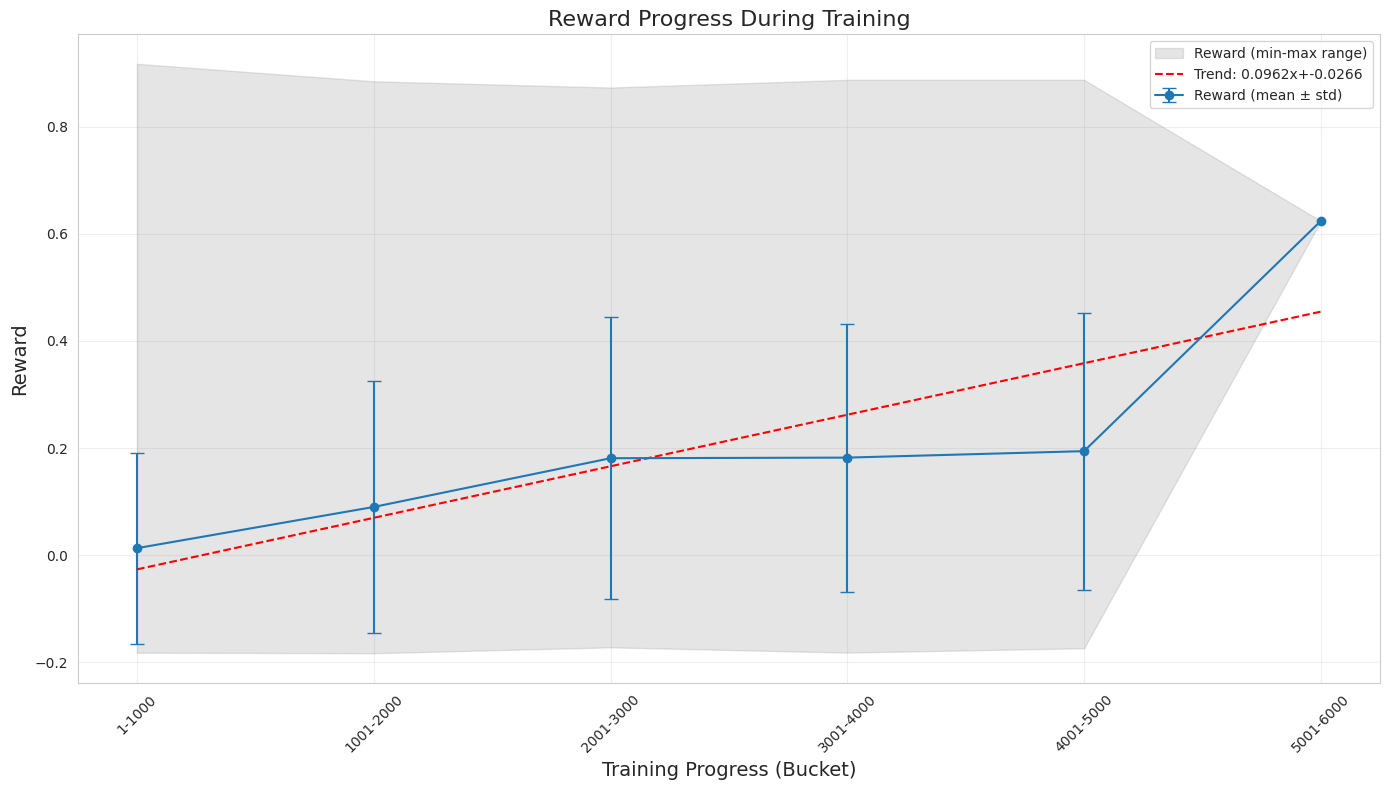


Reward Progress Statistics:


,Bucket,Mean,Std Dev,Min,Max,Episodes
0,1-1000,0.013000,0.177996,-0.182179,0.917314,999
1,1001-2000,0.089930,0.234443,-0.183145,0.884695,1000
2,2001-3000,0.180935,0.263130,-0.172150,0.873012,1000
3,3001-4000,0.182079,0.250369,-0.181992,0.887394,1000
4,4001-5000,0.194139,0.258599,-0.173828,0.887394,1000
5,5001-6000,0.623881,NaN,0.623881,0.623881,1


Overall improvement: 4698.97%
First bucket mean: 0.0130
Last bucket mean: 0.6239
At this rate, performance would double after approximately 106 episodes


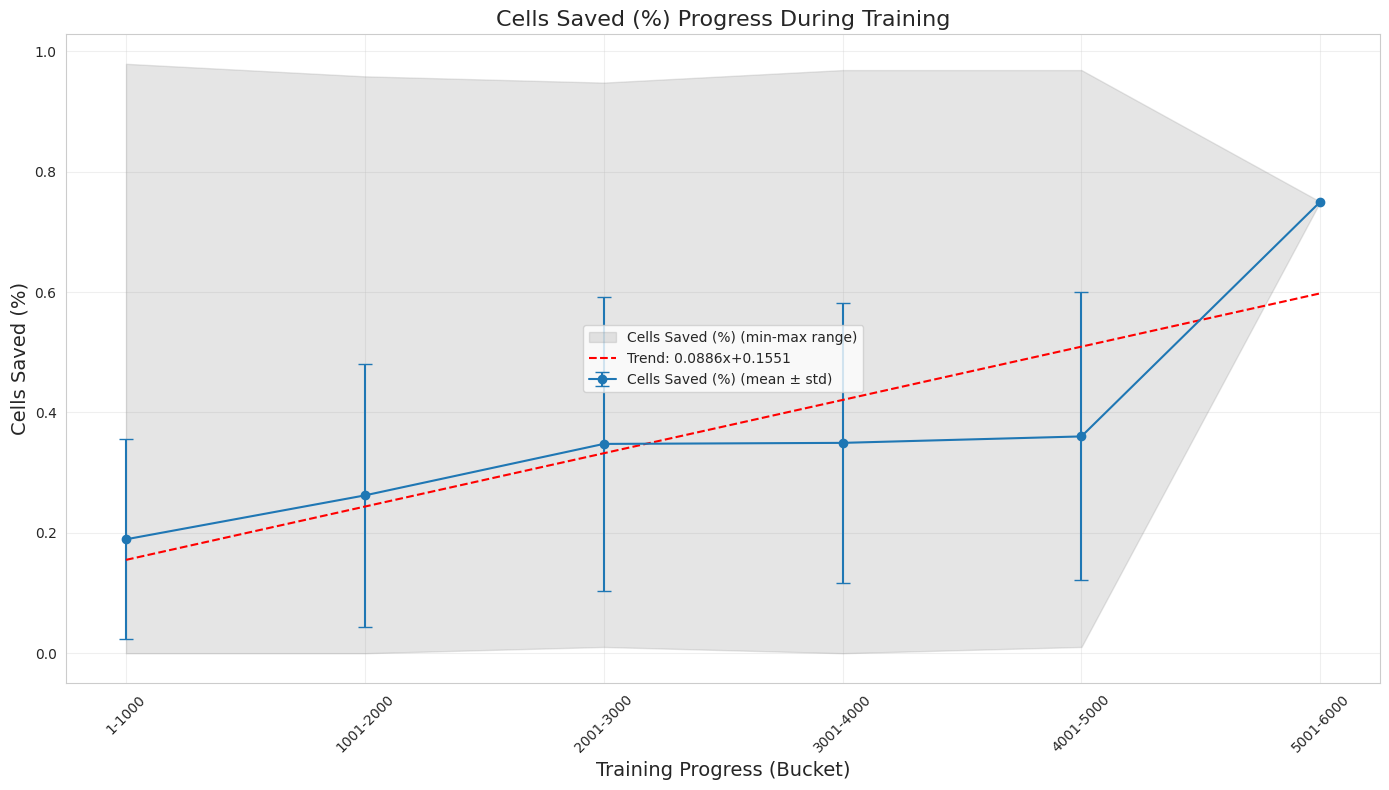


Cells Saved (%) Progress Statistics:


,Bucket,Mean,Std Dev,Min,Max,Episodes
0,1-1000,0.189252,0.166272,0.000000,0.979167,999
1,1001-2000,0.262208,0.218975,0.000000,0.958333,1000
2,2001-3000,0.347719,0.244501,0.010417,0.947917,1000
3,3001-4000,0.349458,0.232562,0.000000,0.968750,1000
4,4001-5000,0.360177,0.239227,0.010417,0.968750,1000
5,5001-6000,0.750000,NaN,0.750000,0.750000,1


Overall improvement: 296.30%
First bucket mean: 0.1893
Last bucket mean: 0.7500
At this rate, performance would double after approximately 1687 episodes


: 

In [ ]:
def analyze_progress(df, num_buckets=10, figsize=(14, 8)):
    """
    Analyze how the cells saved and reward metrics change as training progresses
    by dividing episodes into buckets and comparing performance.
    
    Args:
        df: DataFrame with training log data
        num_buckets: Number of buckets to divide the episodes into
        figsize: Figure size
    """
    # Check if we have the necessary data
    if df is None:
        print("No data available for analysis.")
        return
    
    # Determine which metrics to analyze
    metrics = []
    if 'reward' in df.columns:
        metrics.append(('reward', 'Reward'))
    
    # Find which score column to use
    if 'cells_saved_pct' in df.columns:
        metrics.append(('cells_saved_pct', 'Cells Saved (%)'))
    elif 'cells_saved' in df.columns:
        metrics.append(('cells_saved', 'Cells Saved'))
    
    if not metrics:
        print("No metrics available for analysis.")
        return
    
    # Create buckets based on episode number
    df = df.copy()  # Create copy to avoid modifying original
    max_episode = df['episode'].max()
    bucket_size = max_episode / num_buckets
    df['bucket'] = (df['episode'] // bucket_size).astype(int)
    
    # Calculate statistics for each bucket
    bucket_stats = df.groupby('bucket')[['episode'] + [m[0] for m in metrics]].agg(
        ['mean', 'std', 'min', 'max', 'count']
    )
    
    # Plot progress for each metric
    for metric_col, metric_name in metrics:
        plt.figure(figsize=figsize)
        
        # Extract statistics
        means = bucket_stats[metric_col, 'mean']
        stds = bucket_stats[metric_col, 'std']
        mins = bucket_stats[metric_col, 'min']
        maxs = bucket_stats[metric_col, 'max']
        buckets = means.index
        
        # Plot means with error bars
        plt.errorbar(buckets, means, yerr=stds, fmt='o-', capsize=5,
                     label=f"{metric_name} (mean ± std)")
        
        # Plot min/max as a shaded area
        plt.fill_between(buckets, mins, maxs, alpha=0.2, color='gray',
                         label=f"{metric_name} (min-max range)")
        
        # Add linear trend line
        from scipy import stats
        slope, intercept, r_value, p_value, std_err = stats.linregress(buckets, means)
        x = np.array([buckets.min(), buckets.max()])
        plt.plot(x, intercept + slope * x, 'r--', 
                 label=f'Trend: {slope:.4f}x+{intercept:.4f}')
        
        # Formatting
        plt.title(f'{metric_name} Progress During Training', fontsize=16)
        plt.xlabel('Training Progress (Bucket)', fontsize=14)
        plt.ylabel(metric_name, fontsize=14)
        
        # Add bucket episode ranges as x-tick labels
        tick_labels = []
        for bucket in buckets:
            min_ep = int(bucket * bucket_size) + 1
            max_ep = int((bucket + 1) * bucket_size)
            tick_labels.append(f"{min_ep}-{max_ep}")
        
        plt.xticks(buckets, tick_labels, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Print statistics for this metric
        print(f"\n{metric_name} Progress Statistics:")
        progress_table = pd.DataFrame({
            'Bucket': [f"{int(b*bucket_size)+1}-{int((b+1)*bucket_size)}" for b in buckets],
            'Mean': means.values,
            'Std Dev': stds.values,
            'Min': mins.values,
            'Max': maxs.values,
            'Episodes': bucket_stats[metric_col, 'count'].values
        })
        display(progress_table)
        
        # Calculate and print improvement
        first_bucket_mean = means.iloc[0]
        last_bucket_mean = means.iloc[-1]
        if first_bucket_mean != 0:
            improvement = (last_bucket_mean - first_bucket_mean) / abs(first_bucket_mean) * 100
            print(f"Overall improvement: {improvement:.2f}%")
            print(f"First bucket mean: {first_bucket_mean:.4f}")
            print(f"Last bucket mean: {last_bucket_mean:.4f}")
            
            # Calculate annualized rate of improvement (for hypothetically longer training)
            if improvement > 0:
                episodes_required_to_double = (
                    (100 / improvement) * num_buckets * bucket_size
                )
                print(f"At this rate, performance would double after approximately {int(episodes_required_to_double)} episodes")

# Analyze progress if data is available
if 'df' in locals() and df is not None:
    analyze_progress(df, num_buckets=5)  # Using 5 buckets for clearer visualization
else:
    print("No data available for progress analysis.")